<a href="https://colab.research.google.com/github/tanvir-005/Diabetic-Retinopathy-Detection/blob/main/Workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ✅ SECTION 1: Mount Drive & Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

base_directory = '/content/drive/MyDrive/aptos2019/aptos2019-blindness-detection'
train_csv_path = os.path.join(base_directory, 'train.csv')
test_csv_path = os.path.join(base_directory, 'test.csv')
sample_submission_csv_path = os.path.join(base_directory, 'sample_submission.csv')
train_images_dir = os.path.join(base_directory, 'train_images')
test_images_dir = os.path.join(base_directory, 'test_images')

# Check if base directory and contents exist
if os.path.exists(base_directory):
    print(f"Contents of {base_directory}:")
    for item in os.listdir(base_directory):
        item_path = os.path.join(base_directory, item)
        print(f"- {item} ({'dir' if os.path.isdir(item_path) else 'file'})")
else:
    raise FileNotFoundError(f"{base_directory} not found.")


Mounted at /content/drive
Contents of /content/drive/MyDrive/aptos2019/aptos2019-blindness-detection:
- sample_submission.csv (file)
- test.csv (file)
- train.csv (file)
- train_images (dir)
- test_images (dir)


### 📊 SECTION 2: Load & Explore CSV Data

In [2]:
import pandas as pd

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_csv_path)

print("Train DataFrame:")
display(train_df.head())
print(train_df.info())

print("\nTest DataFrame:")
display(test_df.head())
print(test_df.info())

print("\nSample Submission:")
display(sample_submission_df.head())
print(sample_submission_df.info())


Train DataFrame:


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB
None

Test DataFrame:


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_code  1928 non-null   object
dtypes: object(1)
memory usage: 15.2+ KB
None

Sample Submission:


,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    1928 non-null   object
 1   diagnosis  1928 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.3+ KB
None


### 🖼️ SECTION 3: Display Sample Images

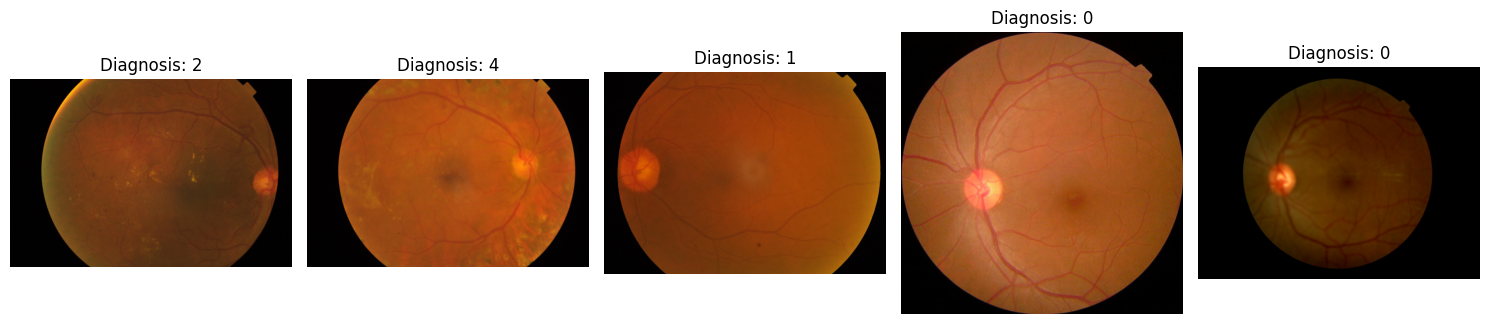

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

train_image_files = [os.path.join(train_images_dir, f"{img_id}.png") for img_id in train_df['id_code']]

plt.figure(figsize=(15, 5))
for i in range(5):
    img = Image.open(train_image_files[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Diagnosis: {train_df.loc[i, 'diagnosis']}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### 🧹 SECTION 4: Image Preprocessing

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 128

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    return img_gray, img  # return both gray and color for feature extraction

X_gray, X_color, y = [], [], []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = os.path.join(train_images_dir, row['id_code'] + '.png')
    try:
        gray_img, color_img = preprocess_image(img_path)
        X_gray.append(gray_img)
        X_color.append(color_img)
        y.append(row['diagnosis'])
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


100%|██████████| 3662/3662 [48:14<00:00,  1.27it/s]


### 🧠 SECTION 5: Feature Extraction

In [5]:
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

def extract_features(gray, color):
    features = []

    # HOG
    hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    features.extend(hog_features)

    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float") / hist.sum()
    features.extend(hist)

    # Color histogram
    for i in range(3):
        hist = cv2.calcHist([color], [i], None, [32], [0, 256]).flatten()
        features.extend(hist)

    # GLCM
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    glcm_features = [
        graycoprops(glcm, prop)[0, 0]
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    ]
    features.extend(glcm_features)

    return features

X_features = [extract_features(gray, color) for gray, color in tqdm(zip(X_gray, X_color), total=len(X_gray))]


100%|██████████| 3662/3662 [01:06<00:00, 54.93it/s]


### 📉 SECTION 6: Dimensionality Reduction (PCA)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_features)


### 🧪 SECTION 7: Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)


### ⚙️ SECTION 8: Train Classifiers

In [ ]:
!pip install catboost


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}


### 📊 SECTION 9: Evaluation


Random Forest Model:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       361
           1       0.52      0.16      0.25        74
           2       0.58      0.85      0.69       200
           3       0.00      0.00      0.00        39
           4       0.60      0.10      0.17        59

    accuracy                           0.73       733
   macro avg       0.51      0.41      0.40       733
weighted avg       0.68      0.73      0.67       733



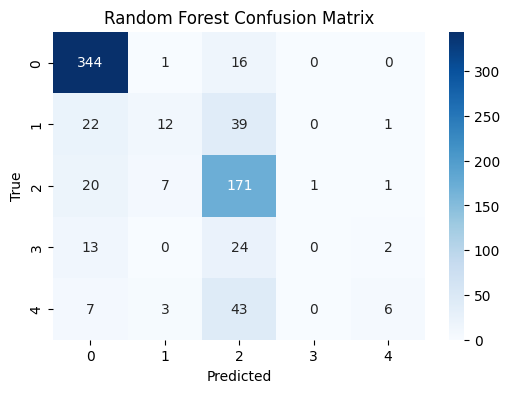


SVM Model:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.83      0.94      0.88       361
           1       0.29      0.05      0.09        74
           2       0.54      0.83      0.66       200
           3       0.67      0.05      0.10        39
           4       0.00      0.00      0.00        59

    accuracy                           0.70       733
   macro avg       0.47      0.38      0.35       733
weighted avg       0.62      0.70      0.63       733



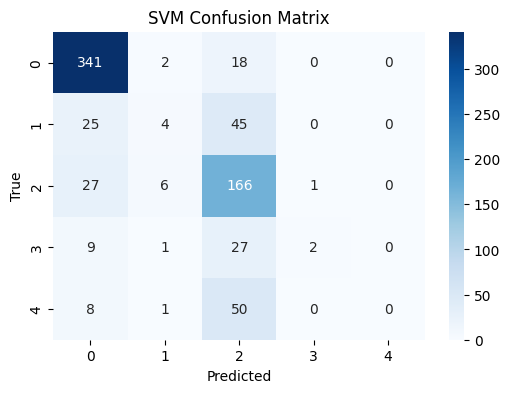


XGBoost Model:


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:04:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       361
           1       0.38      0.20      0.27        74
           2       0.56      0.79      0.65       200
           3       0.33      0.03      0.05        39
           4       0.38      0.14      0.20        59

    accuracy                           0.71       733
   macro avg       0.51      0.42      0.42       733
weighted avg       0.67      0.71      0.67       733



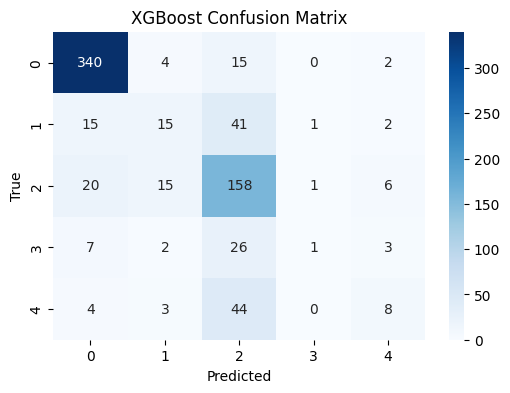


CatBoost Model:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       361
           1       0.37      0.19      0.25        74
           2       0.58      0.81      0.67       200
           3       0.25      0.03      0.05        39
           4       0.45      0.17      0.25        59

    accuracy                           0.72       733
   macro avg       0.51      0.43      0.42       733
weighted avg       0.68      0.72      0.68       733



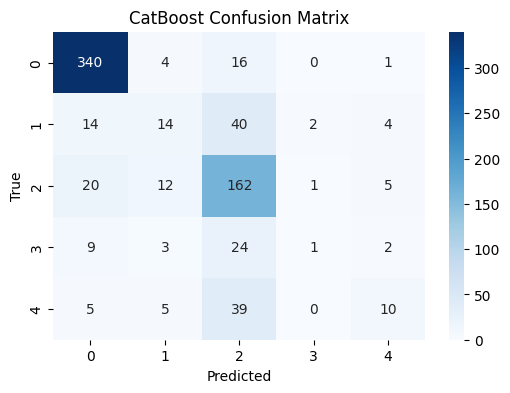

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for name, model in models.items():
    print(f"\n{name} Model:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
